# Mesa demo

In [1]:
# !pip install mesa 'prompt-toolkit==1.0.15' # For google CoLab

## Defining the model

In [ ]:
# Additional Plots
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

In [30]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import random

# Model
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
        
        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},  # A function to call
            agent_reporters={"Wealth": "wealth"})  # An agent attribute 

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

# Agent 
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

In [3]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
# from model import MoneyModel

def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "Layer": 0,
                 "Color": "red",
                 "r": 0.5}
    return portrayal

grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)
server = ModularServer(MoneyModel,
                       [grid],
                       "Money Model",
                       {"N": 100, "width": 10, "height": 10})

In [4]:
# from server import server
# server.port = 8521 # The default
# server.launch()

In [5]:
model = MoneyModel(100, 20, 20)

## Plots 

In [25]:
import matplotlib.pyplot as plt
import numpy as np

In [26]:
%matplotlib notebook
plt.ion()

<IPython.core.display.Javascript object>


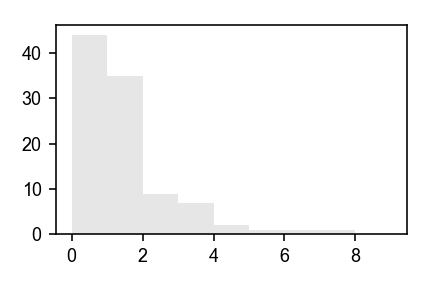

In [31]:
fig1,ax1 = plt.subplots(figsize=(3,2))
fig1.tight_layout()
fig1.show()

<IPython.core.display.Javascript object>


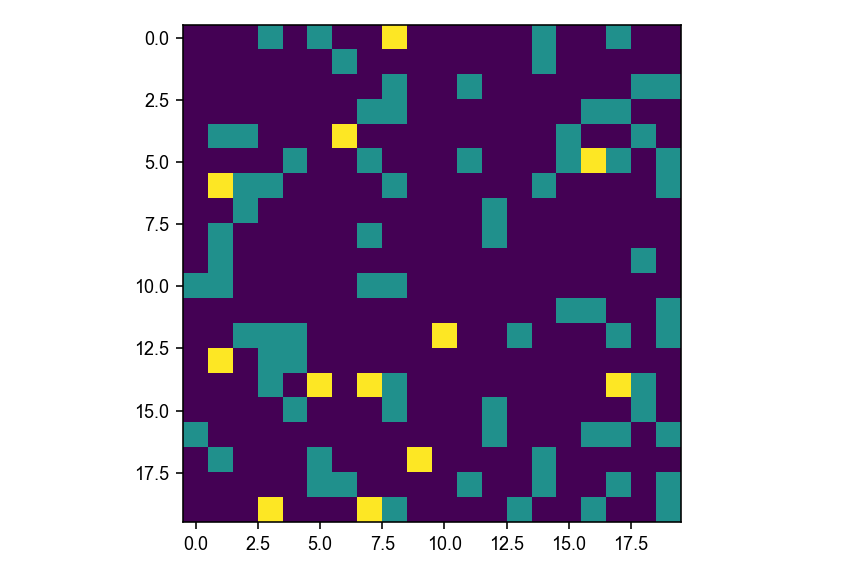

In [33]:
fig2, ax2 = plt.subplots()
fig2.tight_layout()
fig2.show()

In [32]:
# gini = model.datacollector.get_model_vars_dataframe()
# gini.plot()

## Running the Model

In [34]:
from time import sleep
N_LOOPS = 100
SLEEP_TIME = 0.2

for i in range(N_LOOPS):    
    
    # Figure 1
    ax1.cla()
    agent_wealth = [a.wealth for a in model.schedule.agents]
    ax1.hist(agent_wealth, color='.9', bins=range(10))
    fig1.tight_layout()
    fig1.canvas.draw()
    
    # Figure 2
    ax2.cla()
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        agent_count = len(cell_content)
        agent_counts[x][y] = agent_count
    ax2.imshow(agent_counts, interpolation='nearest')
    fig2.tight_layout()
    fig2.canvas.draw()

    # Step model
    sleep(SLEEP_TIME)
    model.step()

KeyboardInterrupt: 